In [1]:
import numpy as np
import numpy.testing as npt
import stumpy
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tqdm import tqdm
tqdm.pandas()

from sklearn.preprocessing import MinMaxScaler

# Examples from Stumpy doc

- https://stumpy.readthedocs.io/en/latest/Tutorial_Pattern_Matching.html
- https://zenodo.org/record/4276393/files/Fast_Pattern_Searching_robot_dog.csv?download=1
- https://zenodo.org/record/4276880/files/carpet_query.csv?download=1
- https://github.com/TDAmeritrade/stumpy

In [2]:
T_df = pd.read_csv('robot.csv')[6000:8000].reset_index(drop=True)
Q_df = pd.read_csv('pattern.csv')

<AxesSubplot:ylabel='Acceleration'>

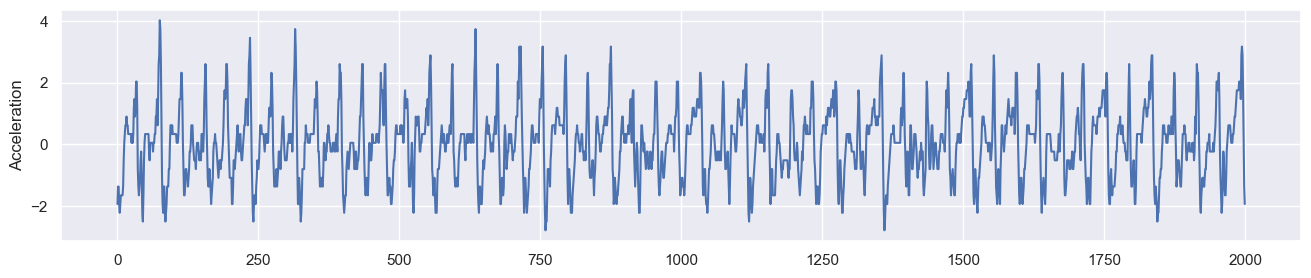

In [3]:
fig,ax = plt.subplots(figsize=(16,3))
sns.lineplot(data=T_df,x=T_df.index,y='Acceleration')

<AxesSubplot:ylabel='Acceleration'>

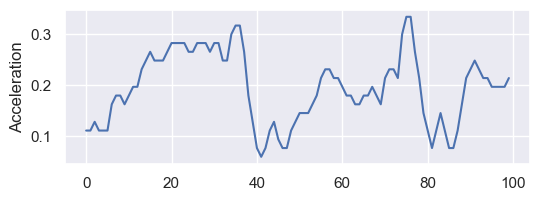

In [4]:
fig,ax = plt.subplots(figsize=(6,2))
sns.lineplot(data=Q_df,x=Q_df.index,y='Acceleration')

In [5]:
distance_profile = stumpy.mass(Q_df["Acceleration"], T_df["Acceleration"])
idx = np.argmin(distance_profile)
print(f"The nearest neighbor to `Q_df` is located at index {idx} in `T_df`")

The nearest neighbor to `Q_df` is located at index 1479 in `T_df`


In [6]:
Q_z_norm = stumpy.z_norm(Q_df.values)
nn_z_norm = stumpy.z_norm(T_df.values[idx:idx+len(Q_df)])

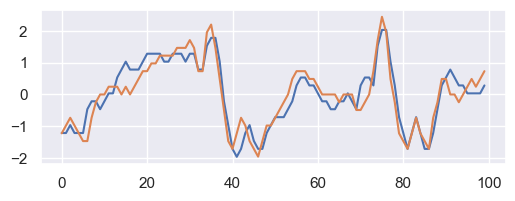

In [7]:
fig,ax = plt.subplots(figsize=(6,2))
plt.plot(Q_z_norm)
plt.plot(nn_z_norm)

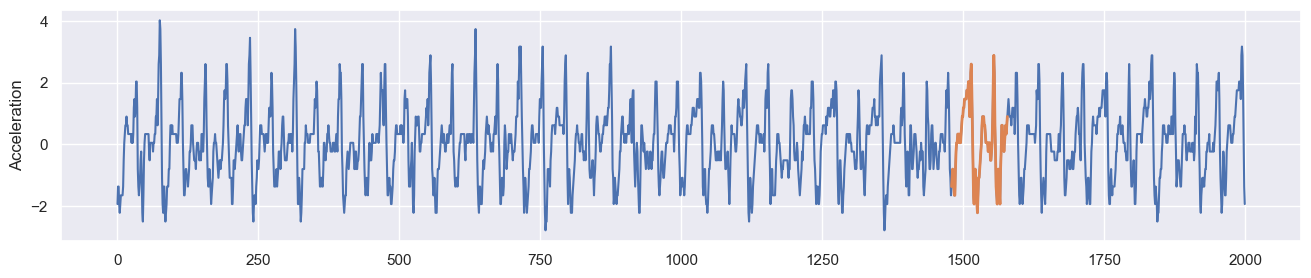

In [8]:
fig,ax = plt.subplots(figsize=(16,3))
sns.lineplot(data=T_df,x=T_df.index,y='Acceleration')
plt.plot(range(idx, idx+len(Q_df)), T_df.values[idx:idx+len(Q_df)], lw=2)

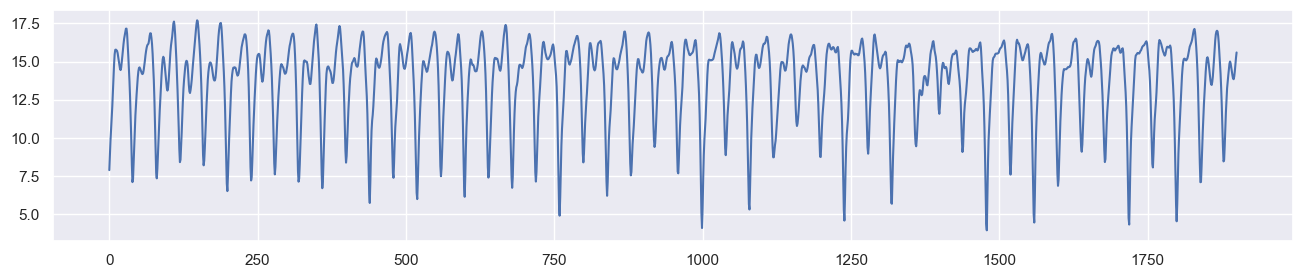

In [9]:
fig,ax = plt.subplots(figsize=(16,3))
plt.plot(distance_profile)

In [10]:
k = 16
idxs = np.argpartition(distance_profile, k)[:k]
idxs = idxs[np.argsort(distance_profile[idxs])]

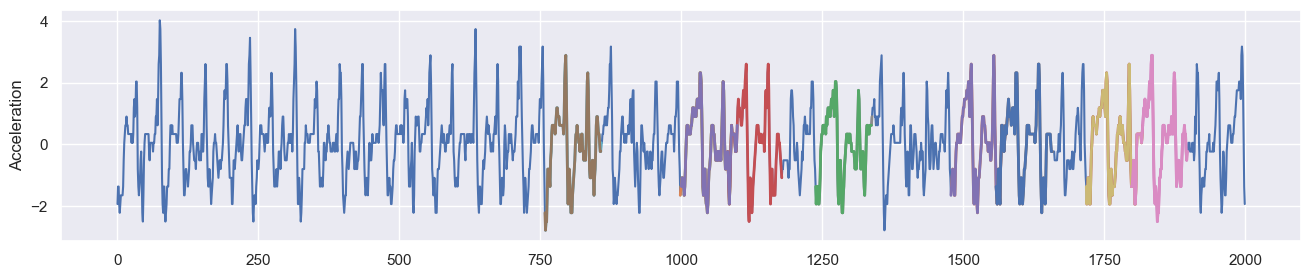

In [11]:
fig,ax = plt.subplots(figsize=(16,3))
sns.lineplot(data=T_df,x=T_df.index,y='Acceleration')
for idx in idxs:
    plt.plot(range(idx, idx+len(Q_df)), T_df.values[idx:idx+len(Q_df)], lw=2)

# PDM telemerty - multivariate

https://www.kaggle.com/datasets/arnabbiswas1/microsoft-azure-predictive-maintenance

In [12]:
df = pd.read_csv('PdM_telem_failures.csv.gz')
df.head()

,datetime,machineID,volt,rotate,pressure,vibration,target
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,0.0
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,0.0
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,0.0
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,0.0
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,0.0


In [13]:
features = ['volt', 'rotate', 'pressure', 'vibration']

In [14]:
# extract pattern on machine 10
pattern = df[df.machineID == 10].reset_index(drop=True)[6000:6300]

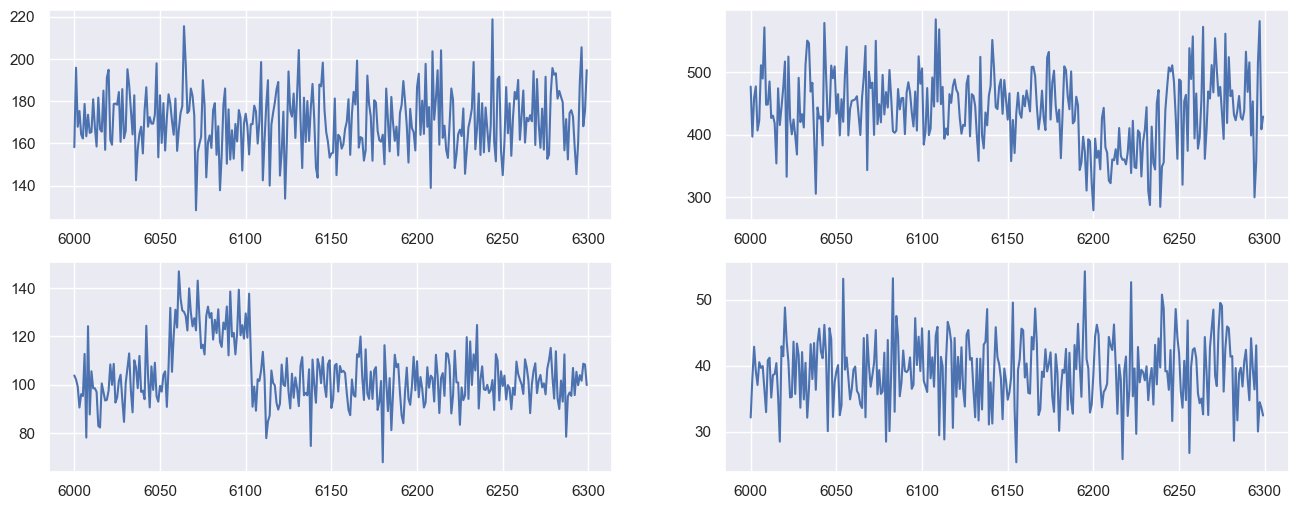

In [15]:
l,c,i = 2,2,1
fig,ax=plt.subplots(figsize=(16,6))
for col in features:
    plt.subplot(l,c,i)
    plt.plot(pattern[col])
    i+=1

In [16]:
df_test = df[df.machineID == 1]

In [17]:
dico_match = {}

for col in tqdm(features):
    dico_match[col] = stumpy.mass(pattern[col].astype(float), df_test[col].astype(float))

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.15s/it]


In [18]:
df_match = pd.DataFrame(dico_match)
df_match_scale = pd.DataFrame(MinMaxScaler().fit_transform(df_match),columns=df_match.columns)
df_match_scale['score'] = df_match_scale.apply(np.linalg.norm, axis=1)

In [19]:
df_match_scale.sort_values('score').head()

,volt,rotate,pressure,vibration,score
2391,0.398091,0.210316,0.098575,0.269737,0.534027
3328,0.122220,0.529283,0.124910,0.335640,0.650642
2375,0.415892,0.080960,0.442167,0.253841,0.662923
2390,0.468954,0.259753,0.049981,0.395259,0.667920
2387,0.670026,0.152608,0.138048,0.135281,0.713851


In [20]:
idx = 2391
df_test.iloc[idx]

datetime     2015-04-10 21:00:00
machineID                      1
volt                  202.677176
rotate                 440.83382
pressure              102.211544
vibration              41.656864
target                       0.0
Name: 2391, dtype: object

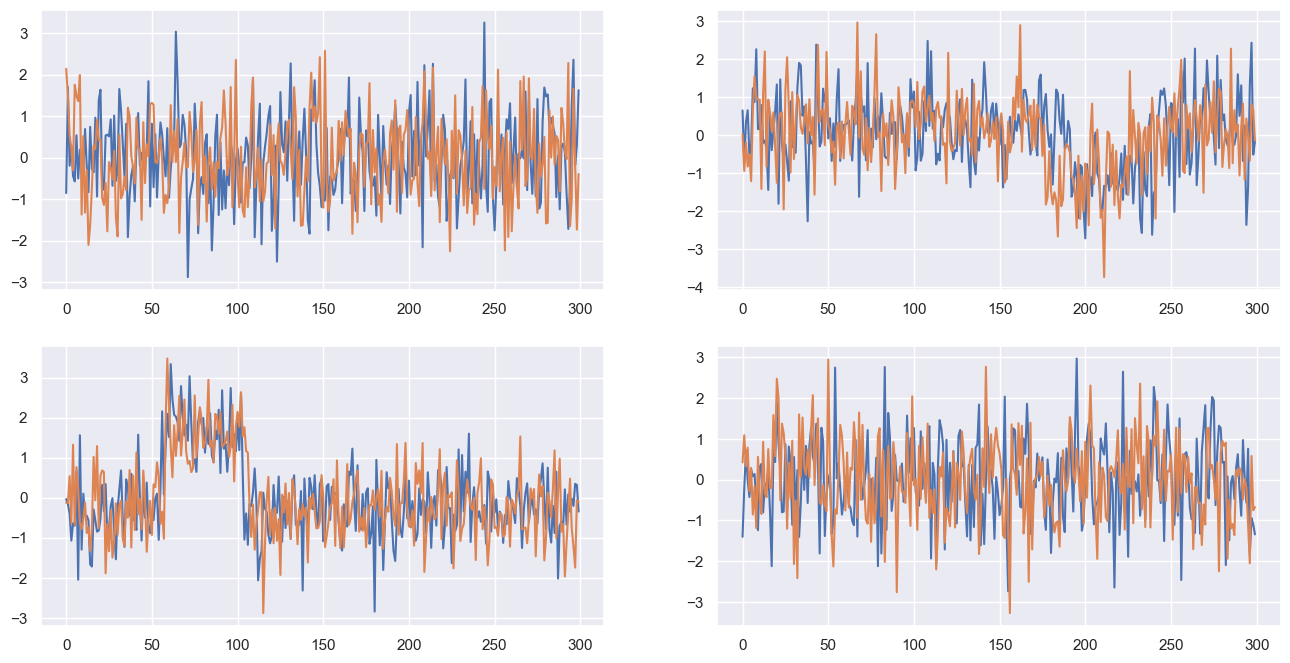

In [21]:
l,c,i = 2,2,1
fig,ax=plt.subplots(figsize=(16,8))

for col in features:
    Q_z_norm = stumpy.z_norm(pattern[col].values)
    nn_z_norm = stumpy.z_norm(df_test[col].values[idx:idx+pattern.shape[0]])
    
    plt.subplot(l,c,i)
    plt.plot(Q_z_norm)
    plt.plot(nn_z_norm)
    i+=1

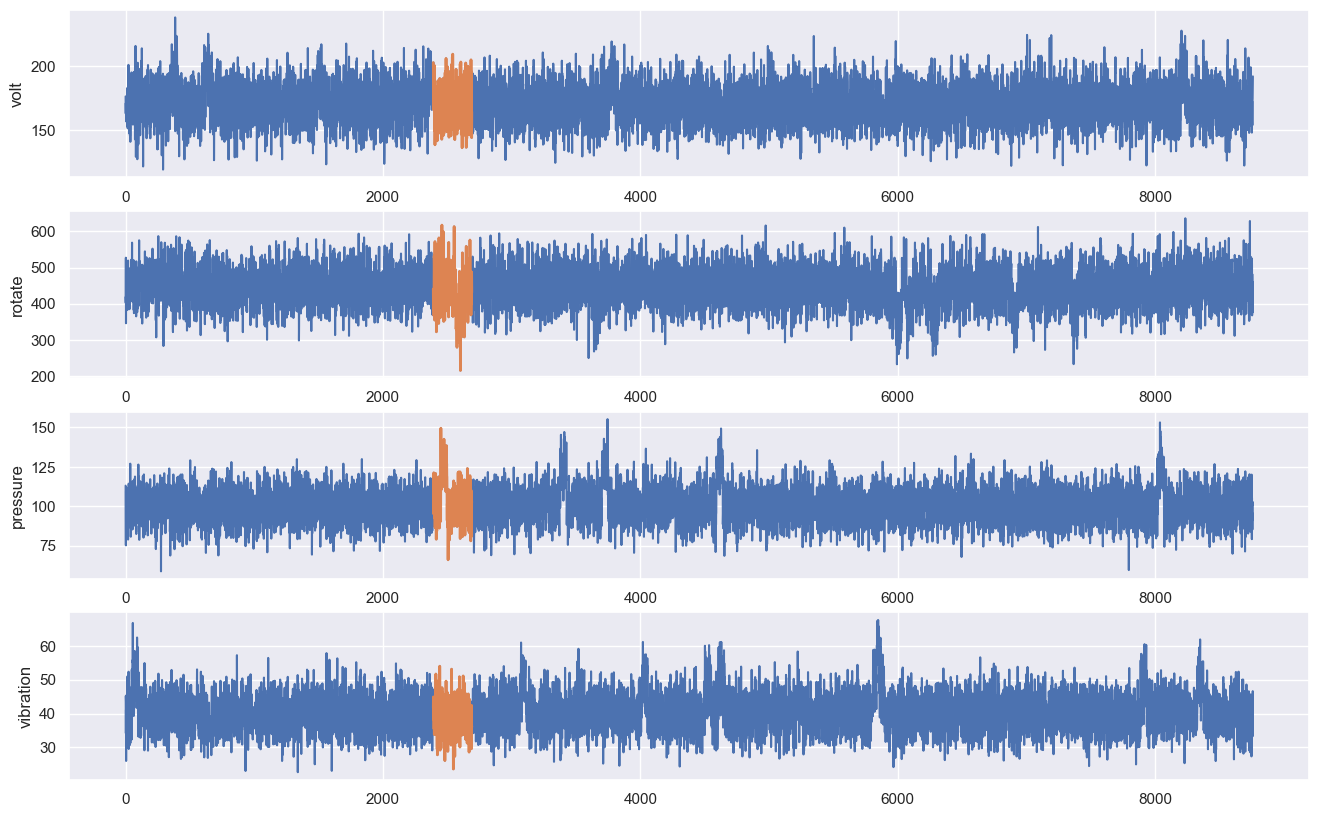

In [22]:
l,c,i = 4,1,1

fig,ax = plt.subplots(figsize=(16,10))
for col in features:
    plt.subplot(l,c,i)
    sns.lineplot(data=df_test,x=df_test.index,y=col)
    plt.plot(range(idx, idx+pattern.shape[0]), df_test[col].values[idx:idx+pattern.shape[0]], lw=2)
    i+=1